In [5]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-12.9/lib64'

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import os
import json
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
import time
import cv2
import numpy as np

# --- НАСТРОЙКИ ---
SOURCE_IMAGES_DIR = Path(r"F:\archive\unique_uis\combined")
PREPARED_DATA_DIR = Path(r"F:\prepared_ui_elements")
annotations_dir = Path('rico_dataset_v0.1_semantic_annotations/semantic_annotations/')

def find_all_elements(data):
    elements = []
    if 'children' in data:
        for child in data['children']:
            elements.append(child)
            elements.extend(find_all_elements(child))
    return elements

# ==============================================================================
# --- ШАГ 1: СБОР ВСЕХ ЭЛЕМЕНТОВ ---
# ==============================================================================
print("\nШаг 1: Сбор ВСЕХ элементов UI из аннотаций...")
all_elements_df_list = []
json_files = list(annotations_dir.glob('*.json'))

for i, json_path in enumerate(json_files):
    if (i + 1) % 5000 == 0:
        print(f"  ...сканирую JSON {i + 1}/{len(json_files)}")

    with open(json_path, 'r', encoding='utf-8') as f:
        ann = json.load(f)

    elements = find_all_elements(ann)
    original_img_filename = f"{json_path.stem}.jpg"

    for elem in elements:
        if 'class' in elem and elem.get('bounds'):
             all_elements_df_list.append({
                 'original_img': original_img_filename,
                 'bounds': elem['bounds'],
                 'full_label': elem['class'] # Назовем столбец 'full_label'
             })

df = pd.DataFrame(all_elements_df_list)

if df.empty:
    raise ValueError("Критическая ошибка: не удалось найти ни одного элемента с ключами 'class' и 'bounds'.")

print(f"\nВсего найдено {len(df)} элементов UI во всех файлах.")


print("\nШаг 2: Упрощение имен классов...")

def simplify_label(full_label):
    """Функция для упрощения длинных имен классов Android."""
    label_lower = full_label.lower()

    if 'textview' in label_lower:
        return 'Text'
    if 'imageview' in label_lower:
        return 'Image'
    if 'button' in label_lower:
        return 'Button'
    if 'icon' in label_lower:
        return 'Icon'
    if 'checkbox' in label_lower:
        return 'CheckBox'
    if 'switch' in label_lower:
        return 'Switch'
    if 'edittext' in label_lower:
        return 'Input'

    return None

# Создаем новый столбец с упрощенными метками
df['label'] = df['full_label'].apply(simplify_label)


df.dropna(subset=['label'], inplace=True)
df = df.astype({'label': 'string'}) # Устанавливаем тип данных для столбца

print("Анализ после упрощения классов:")
class_counts_final = Counter(df['label'])
for cls, count in class_counts_final.most_common():
    print(f"- Класс '{cls}': {count} шт.")


MIN_SAMPLES_PER_CLASS = 1000
valid_classes = [cls for cls, count in class_counts_final.items() if count >= MIN_SAMPLES_PER_CLASS]
df_final = df[df['label'].isin(valid_classes)]

print(f"\nПосле фильтрации осталось {len(df_final)} элементов в {len(valid_classes)} классах.")
print(f"Используемые классы: {valid_classes}")

# ==============================================================================
# --- ШАГ 3 И 4: РАЗДЕЛЕНИЕ И КОПИРОВАНИЕ ---
# ==============================================================================
if df_final.empty:
    raise ValueError("Ошибка: После фильтрации не осталось данных. Попробуйте уменьшить MIN_SAMPLES_PER_CLASS.")

print("\nШаг 3: Разделение на train/validation...")
train_df, val_df = train_test_split(
    df_final,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=df_final['label'] # Стратификация по упрощенным меткам
)
print(f"Обучающая выборка: {len(train_df)} элементов. Валидационная: {len(val_df)} элементов.")

def crop_and_save_elements(dataframe, split_name):
    print(f"\nОбработка '{split_name}' выборки. Вырезаем и сохраняем изображения...")
    count = 0
    skipped_empty = 0 # Счетчик пропущенных пустых изображений

    for index, row in dataframe.iterrows():
        label = row['label']
        bounds = row['bounds']
        original_img_path = SOURCE_IMAGES_DIR / row['original_img']

        dest_dir = PREPARED_DATA_DIR / split_name / label
        os.makedirs(dest_dir, exist_ok=True)

        if original_img_path.exists():
            img = cv2.imread(str(original_img_path))
            if img is None: continue

            x1, y1, x2, y2 = bounds[0], bounds[1], bounds[2], bounds[3]
            if x2 <= x1 or y2 <= y1 or (x2-x1) < 5 or (y2-y1) < 5:
                continue

            cropped_element = img[y1:y2, x1:x2]

            if cropped_element.size == 0:
                skipped_empty += 1
                continue # Пропускаем итерацию, если элемент пустой


            save_path = dest_dir / f"{Path(row['original_img']).stem}_{count}.jpg"
            cv2.imwrite(str(save_path), cropped_element)
            count += 1

            if count % 5000 == 0:
                print(f"  ...сохранено {count} элементов для '{split_name}'")

    print(f"Обработка '{split_name}' завершена. Всего сохранено {count} файлов.")
    if skipped_empty > 0:
        print(f"Было пропущено {skipped_empty} элементов из-за некорректных координат (нулевой размер).")

crop_and_save_elements(train_df, 'train')
crop_and_save_elements(val_df, 'validation')

print("\nПодготовка данных (элементов UI) завершена!")


KeyboardInterrupt



In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-06-18 23:35:21.465427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750278922.310690    2295 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750278922.530429    2295 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750278924.637836    2295 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750278924.637892    2295 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750278924.637894    2295 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1


2025-06-19 16:56:45.846231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750341406.638159    3653 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750341406.843756    3653 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750341408.591545    3653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750341408.591591    3653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750341408.591593    3653 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Mixed precision policy set to "mixed_float16".
Найдено 1 GPU, режим Memory Growth включен.
Запускаем эксперимент: cnn_breakthrough_gelu_bs32_mixed_precision
Создание/проверка кэша...
Found 453427 files belonging to 7 classes.


I0000 00:00:1750342129.753419    3653 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


Found 113285 files belonging to 7 classes.
Конвейер данных готов.

--- Новая архитектура модели ---


Model: "cnn_breakthrough_gelu_bs32_mixed_precision"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_model_v2 (Sequential)      │ (None, 7)              │    67,357,255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,357,255 (256.95 MB)

 Trainable params: 67,355,527 (256.94 MB)

 Non-trainable params: 1,728 (6.75 KB)


--- Начало обучения модели ---
Первая эпоха может быть долгой из-за создания файлов кэша...
Epoch 1/50


I0000 00:00:1750342316.523863    5556 cuda_dnn.cc:529] Loaded cuDNN version 90300


14170/14170 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6040 - loss: 1.0353
Epoch 1: val_accuracy improved from -inf to 0.69497, saving model to cnn_breakthrough_gelu_bs32_mixed_precision_best_model.keras


2025-06-19 18:11:54.019708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:333] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


14170/14170 ━━━━━━━━━━━━━━━━━━━━ 3610s 253ms/step - accuracy: 0.6040 - loss: 1.0353 - val_accuracy: 0.6950 - val_loss: 0.8541
Epoch 2/50


2025-06-19 18:12:01.302895: W tensorflow/core/kernels/data/cache_dataset_ops.cc:333] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


14170/14170 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.6760 - loss: 0.8748
Epoch 2: val_accuracy improved from 0.69497 to 0.71152, saving model to cnn_breakthrough_gelu_bs32_mixed_precision_best_model.keras
14170/14170 ━━━━━━━━━━━━━━━━━━━━ 3704s 261ms/step - accuracy: 0.6760 - loss: 0.8748 - val_accuracy: 0.7115 - val_loss: 0.8243
Epoch 3/50
14170/14170 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6899 - loss: 0.8439
Epoch 3: val_accuracy improved from 0.71152 to 0.72105, saving model to cnn_breakthrough_gelu_bs32_mixed_precision_best_model.keras
14170/14170 ━━━━━━━━━━━━━━━━━━━━ 3590s 253ms/step - accuracy: 0.6899 - loss: 0.8439 - val_accuracy: 0.7210 - val_loss: 0.7854
Epoch 4/50
14170/14170 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6970 - loss: 0.8286
Epoch 4: val_accuracy did not improve from 0.72105
14170/14170 ━━━━━━━━━━━━━━━━━━━━ 3904s 276ms/step - accuracy: 0.6970 - loss: 0.8286 - val_accuracy: 0.7125 - val_loss: 0.8281
Epoch 5/50
14170/14170 ━━━━━━━━━━━━━━━━━━━

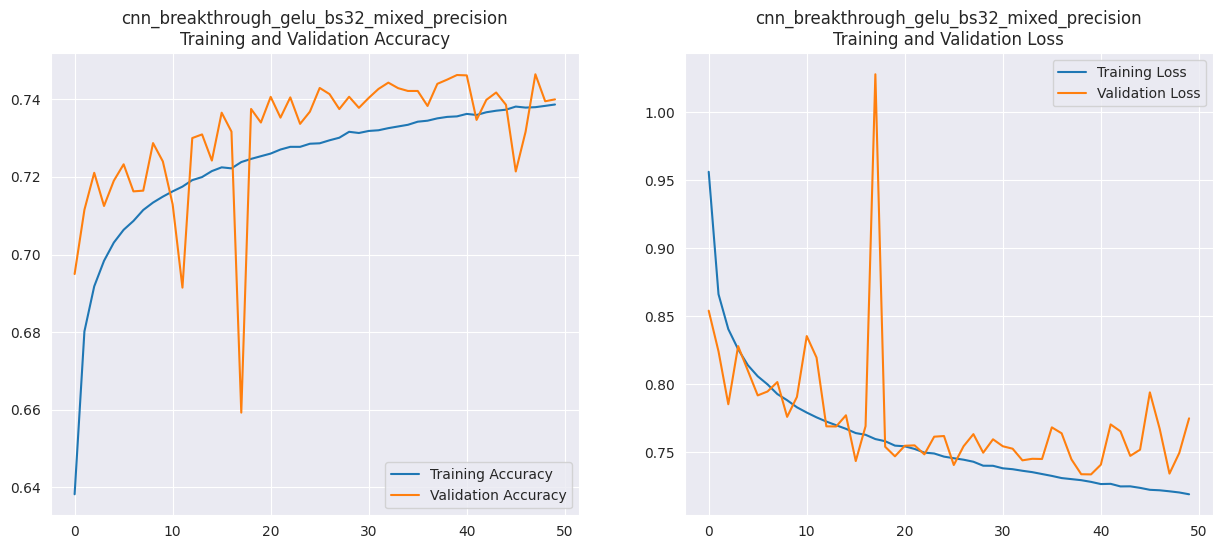


Оценка лучшей сохраненной модели...
Точность лучшей модели на валидационных данных: 0.7464
3541/3541 ━━━━━━━━━━━━━━━━━━━━ 274s 77ms/step


2025-06-21 22:19:28.754489: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


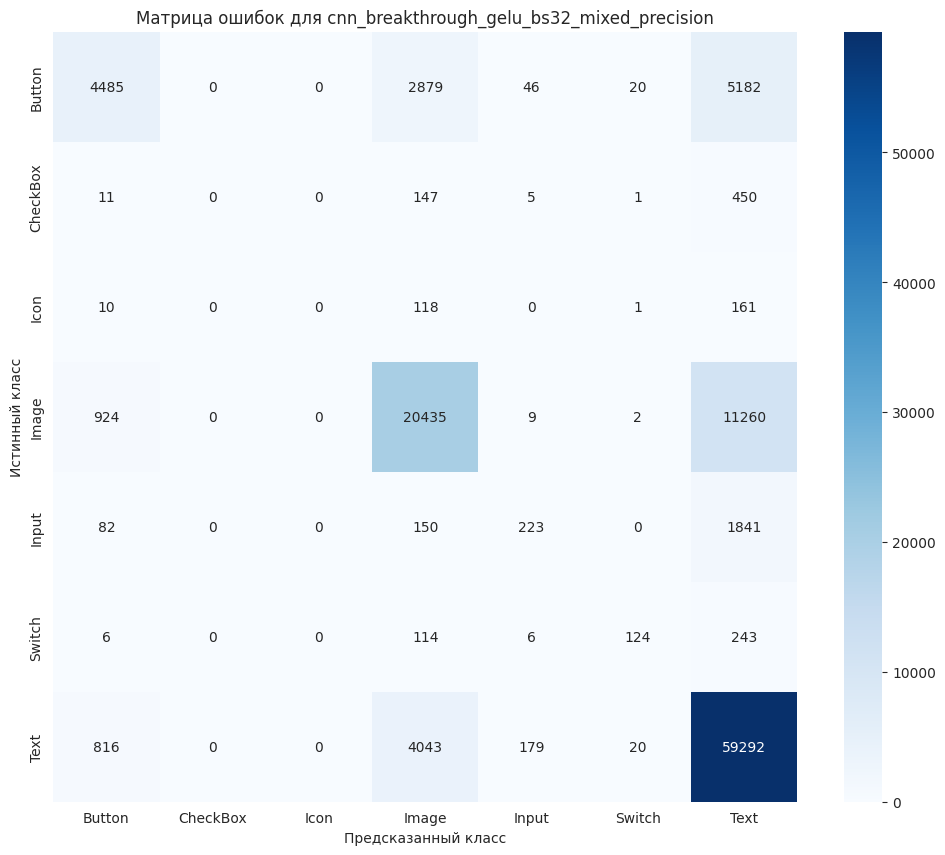


Отчет по классификации:
              precision    recall  f1-score        support
Button         0.708083  0.355614  0.473451   12612.000000
CheckBox       0.000000  0.000000  0.000000     614.000000
Icon           0.000000  0.000000  0.000000     290.000000
Image          0.732805  0.626264  0.675359   32630.000000
Input          0.476496  0.097125  0.161360    2296.000000
Switch         0.738095  0.251521  0.375189     493.000000
Text           0.755996  0.921399  0.830542   64350.000000
accuracy       0.746427  0.746427  0.746427       0.746427
macro avg      0.487354  0.321703  0.359414  113285.000000
weighted avg   0.732207  0.746427  0.723917  113285.000000

--- Визуализация предсказаний на случайных примерах ---


2025-06-21 22:19:29.995693: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


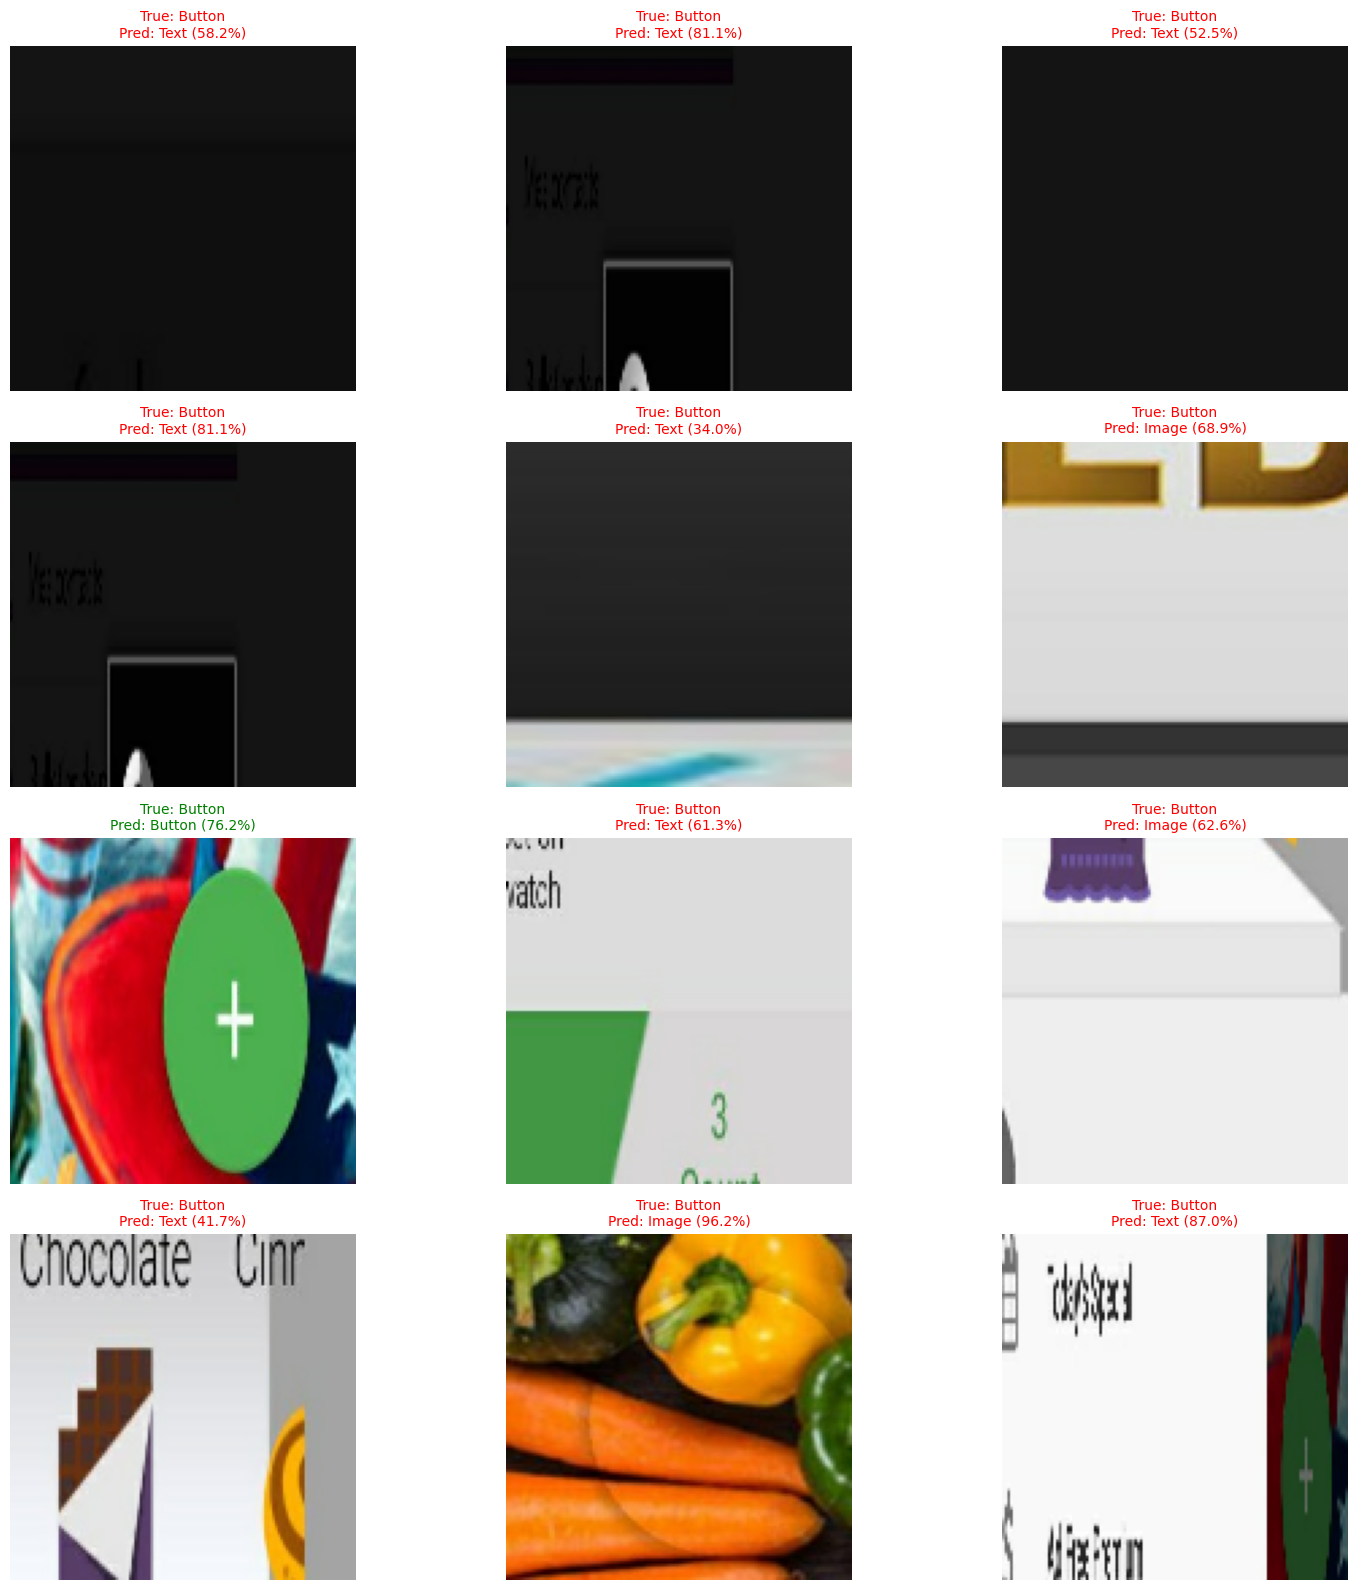


Анализ для эксперимента 'cnn_breakthrough_gelu_bs32_mixed_precision' завершен. Все артефакты сохранены в текущей папке.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import time

print("TensorFlow version:", tf.__version__)


from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Mixed precision policy set to "mixed_float16".')
# =================================================================================

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Найдено {len(gpus)} GPU, режим Memory Growth включен.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU не найдено. Обучение будет происходить на CPU.")


PREPARED_DATA_DIR = Path("/mnt/f/prepared_ui_elements")


IMG_SIZE = 128
BATCH_SIZE = 32


LEARNING_RATE = 0.001
EPOCHS = 50
EXPERIMENT_NAME = f"cnn_breakthrough_gelu_bs{BATCH_SIZE}_mixed_precision"
print(f"Запускаем эксперимент: {EXPERIMENT_NAME}")

# Загрузка данных с кэшированием на диск
cache_dir = Path("/mnt/f/tf_cache")
cache_dir.mkdir(exist_ok=True)
train_cache_file = str(cache_dir / f"train_img{IMG_SIZE}.tfcache")
val_cache_file = str(cache_dir / f"val_img{IMG_SIZE}.tfcache")

print("Создание/проверка кэша...")


train_dataset = tf.keras.utils.image_dataset_from_directory(
    PREPARED_DATA_DIR / 'train', label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, shuffle=True, seed=42
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    PREPARED_DATA_DIR / 'validation', label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_dataset.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache(filename=train_cache_file).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache(filename=val_cache_file).prefetch(buffer_size=AUTOTUNE)
print("Конвейер данных готов.")


data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
], name='data_augmentation')


model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255),

    # Блок 1
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Блок 2
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # "Голова"
    layers.Flatten(),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax', dtype='float32')
], name="base_model_v2")
# =================================================================================


inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
outputs = model(x)
full_model = tf.keras.Model(inputs, outputs, name=EXPERIMENT_NAME)


optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

full_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Новая архитектура модели ---")
full_model.summary()


print("\n--- Начало обучения модели ---")
print("Первая эпоха может быть долгой из-за создания файлов кэша...")
start_time = time.time()

checkpoint_path = f"{EXPERIMENT_NAME}_best_model.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
)

history = full_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint, early_stopping]
)

end_time = time.time()
print(f"\n--- Обучение завершено за {(end_time - start_time) / 60:.2f} минут ---")



print("\n--- Анализ результатов эксперимента ---")

# --- 5.1. Графики точности и потерь ---
def plot_history(history, experiment_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{experiment_name}\nTraining and Validation Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{experiment_name}\nTraining and Validation Loss')
    plt.grid(True)

    # Сохраняем график в файл
    plt.savefig(f"{experiment_name}_training_plots.png")
    plt.show()

plot_history(history, EXPERIMENT_NAME)


print("\nОценка лучшей сохраненной модели...")
# Загружаем лучшую модель, сохраненную колбэком
best_model = tf.keras.models.load_model(checkpoint_path)

loss, accuracy = best_model.evaluate(validation_dataset, verbose=0)
print(f"Точность лучшей модели на валидационных данных: {accuracy:.4f}")

# Получаем предсказания и истинные метки
y_pred_probs = best_model.predict(validation_dataset, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y.numpy() for x, y in validation_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Матрица ошибок для {EXPERIMENT_NAME}')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.savefig(f"{EXPERIMENT_NAME}_confusion_matrix.png")
plt.show()

# Отчет по классификации (precision, recall, f1-score)
print("\nОтчет по классификации:")
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, output_dict=True)
# Вывод в красивом виде
import pandas as pd
df_report = pd.DataFrame(report).transpose()
print(df_report)
# Сохранение отчета в файл
df_report.to_csv(f"{EXPERIMENT_NAME}_classification_report.csv")


print("\n--- Визуализация предсказаний на случайных примерах ---")
def visualize_predictions(model, dataset, num_images=12):
    plt.figure(figsize=(16, 16))
    # Берем один батч из датасета
    for images, labels in dataset.take(1):
        # В модели для предсказаний не нужна аугментация
        predictions = model.predict(images, verbose=0)
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(4, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            true_label = class_names[np.argmax(labels[i])]
            predicted_label = class_names[np.argmax(predictions[i])]
            confidence = 100 * np.max(predictions[i])

            color = "green" if predicted_label == true_label else "red"

            plt.title(f"True: {true_label}\nPred: {predicted_label} ({confidence:.1f}%)", color=color, fontsize=10)
            plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"{EXPERIMENT_NAME}_predictions_visualization.png")
    plt.show()

visualize_predictions(best_model, validation_dataset)

print(f"\nАнализ для эксперимента '{EXPERIMENT_NAME}' завершен. Все артефакты сохранены в текущей папке.")